In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
recalc_means = False #recalculate the groupwise mean stats set to False to load from file

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
trial_db = h5py.File('../02_imaging_post_processing/trial_db.hdf5','a')
#epoch_db = h5py.File('../02_imaging_post_processing/epoch_db_nnls_fits_bk_sub_F.hdf5','a')

In [4]:
# function to get the timebase using the trial name (yaw_left)
def get_xio(trial_name):
    xi = np.linspace(0,23,1150)
    #print trial_name
    if trial_name in ['ascending','descending','yaw_left','yaw_right','progressive','regressive']:
        xi -= 10.0
    if 'pth_roll' in trial_name:
        xi -= 7.0
    if 'flight' in trial_name:
        xi -= 5.0
    else:
        return xi
    return xi

In [9]:
import group_data as gd
trial_types = set(trial_db['trial_names'])
test_set = list(trial_types.difference(['flight_starts','flight_stops','stripe_fix']))
fly_set = set(gd.GMR22H05_list)
#fly_set = set(gd.GMR40D04_pr_list)

In [3]:
data = dict()
data['exp_names'] = np.array(trial_db['exp_names'])
data['fly_numbers'] = np.array(trial_db['fly_numbers'])
data['genotypes'] = np.array(trial_db['genotypes'])
#data['signal_data'] = np.array(trial_db['signal_names'])
data['trial_names'] = np.array(trial_db['trial_names'])
#data['flt_samples'] = np.array(trial_db['flt_samples'])

In [6]:
#mask out the data so only the trial types in test_set will be included
mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for trial_name in test_set:
    mask = mask | (data['trial_names'] == trial_name)

#now mask out the data to only include the flys in fly_set
fly_mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for fly in fly_set:
    fly_mask = fly_mask | (data['fly_numbers'] == fly)
mask = mask & fly_mask
#data['trial_names'] == list(test_set)[0])

In [7]:
trial_to_label = dict()
[trial_to_label.update({tname:tname}) for tname in trial_types]

[trial_to_label.update({tname:'PR' + tname.split('_')[-1]}) 
    for tname in trial_types if 'pth_roll' in tname]

trial_to_label['step_roll_yaw_000'] = 'RL'#\n00'
trial_to_label['step_roll_yaw_090'] = 'YR'#\n90'
trial_to_label['step_roll_yaw_180'] = 'RR'#\n180'
trial_to_label['step_roll_yaw_270'] = 'YL'#\n270'

trial_to_label['ascending'] = 'DEC'
trial_to_label['descending'] = 'ASC'
trial_to_label['progressive'] = 'REG'
trial_to_label['regressive'] = 'PRO'

trial_to_label['pth_roll_0'] = 'PU'#\n00'
trial_to_label['pth_roll_90'] = 'RR'#\n90'
trial_to_label['pth_roll_180'] = 'PD'#\n180'
trial_to_label['pth_roll_270'] = 'RL'#\n270'

trial_to_label['yaw_left'] = 'YR'
trial_to_label['yaw_right'] = 'YL'

In [8]:
[data.update({sig:np.array(trial_db[sig])}) for sig in trial_db.keys() if not(sig in ['exp_names',
                                                                                        'fly_numbers',
                                                                                        'genotypes',
                                                                                        'signal_units',
                                                                                        'swarm_names',
                                                                                        'trial_names',
                                                                                        'trial_numbers',
                                                                                        'trial_times'])];

In [8]:
# Create a selection array to include only fly's that flew for for the entire trial - the number of samples
# with a wing-beat frequency > 100  was equal to the number of samples in the trial
xi = get_xio('yaw_left')
flt_selection = np.nansum(np.array(trial_db['wb_frequency']) > 100,axis = 1)>=xi[-1]

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


In [2]:
!rm saccade_analysis_data.hdf5

In [75]:
xi = get_xio('yaw_left')
flt_selection = np.nansum(np.array(trial_db['wb_frequency']) > 100,axis = 1)>=xi[-1]

def get_selection_mtrx(signal,trial):
    selection = flt_selection & \
                mask & \
                (data['trial_names'] == trial)
    return data[signal][selection] 

def get_norm_term(signal):
    selection = flt_selection & \
                mask
    data_selection = data[signal][selection]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    return np.nanstd(subtracted_selection[:,baseline_idx])

signal_norms = dict()

[signal_norms.update({sig:get_norm_term(sig)}) for sig in trial_db.keys() if not(sig in ['exp_names',
                                                                                        'fly_numbers',
                                                                                        'genotypes',
                                                                                        'signal_units',
                                                                                        'swarm_names',
                                                                                        'trial_names',
                                                                                        'trial_numbers',
                                                                                        'trial_times'])];


saccade_metadata.create_group('normed_signals')
saccade_metadata['normed_signals'].create_dataset('Ph0',data = data['Ph0']/signal_norms['Ph0'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('Ph1',data = data['Ph1']/signal_norms['Ph1'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('Ph2',data = data['Ph2']/signal_norms['Ph2'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('b1',data = data['b1']/signal_norms['b1'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('b2',data = data['b2']/signal_norms['b2'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('b3',data = data['b3']/signal_norms['b3'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('i1',data = data['i1']/signal_norms['i1'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('i2',data = data['i2']/signal_norms['i2'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('hg1',data = data['hg1']/signal_norms['hg1'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('hg2',data = data['hg2']/signal_norms['hg2'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('hg3',data = data['hg3']/signal_norms['hg3'],compression = 'gzip')
saccade_metadata['normed_signals'].create_dataset('hg4',data = data['hg4']/signal_norms['hg4'],compression = 'gzip')

In [10]:
xi = get_xio('yaw_left')
flt_selection = np.nansum(np.array(trial_db['wb_frequency']) > 100,axis = 1)>=xi[-1]

def get_selection_mtrx(signal,trial):
    selection = flt_selection & \
                mask & \
                (data['trial_names'] == trial)
    return data[signal][selection] 

def get_norm_term(signal):
    selection = flt_selection & \
                mask
    data_selection = data[signal][selection]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    return np.nanstd(subtracted_selection[:,baseline_idx])

signal_norms = dict()

[signal_norms.update({sig:get_norm_term(sig)}) for sig in trial_db.keys() if not(sig in ['exp_names',
                                                                                        'fly_numbers',
                                                                                        'genotypes',
                                                                                        'signal_units',
                                                                                        'swarm_names',
                                                                                        'trial_names',
                                                                                        'trial_numbers',
                                                                                        'trial_times'])];

def get_sort_idx(signal,trial):
    data_selection = get_selection_mtrx(signal,trial)
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>0) & (xi <3))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    normed_selection = subtracted_selection/signal_norms[signal]
    #normed_selection = subtracted_selection/ np.nanstd(subtracted_selection[:,baseline_idx])
    sort_idx = argsort(mean(normed_selection[:,stim_idx],axis = 1))
    return sort_idx

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [11]:
def get_normed_trialmtrx(signal,trial):
    data_selection = get_selection_mtrx(signal,trial)
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>0) & (xi <3))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    normed_selection = subtracted_selection/ signal_norms[signal]
    sort_idx = get_sort_idx('Ph2',trial)
    return normed_selection[sort_idx[::-1]]

In [12]:
selection = flt_selection & \
            mask
selection_idx = np.squeeze(argwhere(selection))

In [15]:
ground_truth_idx = np.random.choice(selection_idx,100,replace = False)

In [280]:
f= open('sorted_trials.cpkl','rb')
import cPickle
sorted_trials = cPickle.load(f)
f.close()
print ('%s trials inspected'%(len(sorted_trials.keys())))
inspected_idxs = set(sorted_trials.keys())
ground_truth_idx = set(ground_truth_idx).difference(sorted_trials.keys())
print ('%s trials still in ground_truth_idx to inspect')%(len(ground_truth_idx))
ground_truth_idx = np.array([x for x in ground_truth_idx])

32 trials inspected
100 trials still in ground_truth_idx to inspect


In [281]:
repnum = 0

In [372]:
trace_idx = ground_truth_idx[repnum]
xi = xi
lmr = data['Ph2'][trace_idx]/signal_norms['Ph1']
lmr[isnan(lmr)] = 0
lmr[~isfinite(lmr)] = 0

from bokeh.models import CustomJS, ColumnDataSource, BoxSelectTool, PanTool,WheelZoomTool,Range1d, Rect
from bokeh.plotting import figure, output_notebook, show

output_notebook()

source = ColumnDataSource(data=dict(x=[], y=[], width=[], height=[]))

callback = CustomJS(args=dict(source=source), code="""
        // get data source from Callback args
        var data = source.get('data');

        /// get BoxSelectTool dimensions from cb_data parameter of Callback
        var geometry = cb_data['geometry'];

        /// calculate Rect attributes
        var width = geometry['x1'] - geometry['x0'];
        var height = geometry['y1'] - geometry['y0'];
        var x = geometry['x0'] + width/2;
        var y = geometry['y0'] + height/2;

        /// update data source with new Rect attributes
        data['x'].push(x);
        data['y'].push(y);
        data['width'].push(width);
        data['height'].push(height);

        // trigger update of data source
        source.trigger('change');

        // Define a callback to capture errors on the Python side
        function callback(msg){
            console.log("Python callback returned unexpected message:", msg)
        }
        callbacks = {iopub: {output: callback}};

        // Generate a command to execute in Python
        var ranges = {x: data['x'],
                      w: data['width']}
        var range_str = JSON.stringify(ranges)
        var cmd = "%s(" + range_str + ")"

        // Execute the command on the Python kernel
        var kernel = IPython.notebook.kernel;
        kernel.execute(cmd, callbacks, {silent : false});     
    """%'print_vals')

selections = list()
saccades = None

def print_vals(ranges):
    global selections
    selections = ranges

def log_saccads():
    global selections
    saccades = [{'x0':x0-w/2.0,'x1':x0+w/2.0} for x0,w in zip(selections['x'],selections['w'])]
    saccades = [argwhere((s['x0'] < xi) & (s['x1'] > xi)) for s in saccades]
    return saccades

box_select = BoxSelectTool(callback=callback,dimensions = ['width'])
pan_tool = PanTool(dimensions = ['width'])
zoom_tool = WheelZoomTool(dimensions = ['width'])

TOOLS="resize,crosshair,pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"

p = figure(plot_width=800,
           plot_height=400,
           tools=[box_select,pan_tool,zoom_tool],
           title="Identify Saccades",
           x_range=Range1d(start=xi[0], end=xi[-1]/5.0),
           y_range=Range1d(start=np.min(lmr), end=np.max(lmr)))

rect = Rect(x='x',
            y='y',
            width='width',
            height='height',
            fill_alpha=0.3,
            fill_color='#009933')

p.add_glyph(source, rect, selection_glyph=rect, nonselection_glyph=rect)

p.line(xi,lmr)
show(p)

Loading BokehJS ...

In [373]:
sorted_trials.update({trace_idx:log_saccads()})

In [374]:
repnum += 1
print repnum

27


In [375]:
print len(sorted_trials)

50


In [376]:
f= open('sorted_trials.cpkl','wb')
import cPickle
cPickle.dump(sorted_trials,f)
f.close()

## Generate a saccade detector and apply the detector to the ground truth data to determine the appropriate settings 

In [14]:
f= open('sorted_trials.cpkl','rb')
import cPickle
annotated_trials = cPickle.load(f)
f.close()

In [15]:
for key in annotated_trials.keys():
    if key > 15443:
        annotated_trials.pop(key)

In [16]:
norm_term = get_norm_term('Ph2')
ground_truth_lmr = np.array([data['Ph2'][trace_idx]/norm_term for trace_idx in annotated_trials.keys()])

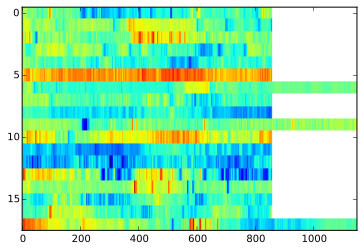

In [17]:
imshow(ground_truth_lmr,aspect = 'auto', interpolation = 'nearest')
ground_truth_mtrx = zeros_like(ground_truth_lmr)
#construct binary matrix of annotated data
for i,elist in enumerate(annotated_trials.values()):
    for event in elist:
        ground_truth_mtrx[i,event] = 1
ground_truth_mtrx = (ground_truth_mtrx>0)

In [18]:
def detect_saccades(lmr_mtrx,kernel_size=12,mysize=21,thresh=2):
    import scipy.signal
    import flylib as flb
    reload(flb)
    trenddata = apply_along_axis(scipy.signal.medfilt,1,lmr_mtrx,kernel_size = kernel_size)
    detrend = lmr_mtrx-trenddata
    detrend[isnan(detrend)] = 0
    detrend = apply_along_axis(scipy.signal.wiener,1,detrend,mysize =mysize)
    #event_mtrx = abs(detrend)>thresh
    event_lists = [flb.idx_by_thresh(sweep,thresh) for sweep in abs(detrend)]
    event_lists = [[event for event in event_list if (len(event)>0) and not(event is None)] for event_list in event_lists if event_list]
    return event_lists

def convert_events_to_mtrx(event_lists,output_shape,scalings = 1):
    event_mtrx = np.zeros(output_shape)
    if type(scalings) is list:
        for i,(elist,slist) in enumerate(zip(event_lists,scalings)):
            for event,scailing in zip(elist,slist):
                event_mtrx[i,event] = scailing
        return event_mtrx
    for i,elist in enumerate(event_lists):
        for event in elist:
            event_mtrx[i,event] = scalings
    return (event_mtrx > 0)
    
def get_putative_saccade_mtrx(ksize,mysize,thresh):
    putative_saccades = detect_saccades(ground_truth_lmr,ksize,mysize,thresh)
    putative_saccade_mtrx = convert_events_to_mtrx(putative_saccades,shape(ground_truth_lmr))
    return (putative_saccade_mtrx > 0)

In [19]:
def match_test(ep0,ep1):
    c0 = ep0[0] + (ep0[-1]-ep0[0])/2
    c1 = ep1[0] + (ep1[-1]-ep1[0])/2
    test1 = (c1>ep0[0]) & (c1<ep0[-1])
    test2 = (c0>ep1[0]) & (c0<ep1[-1])
    return test1 & test2

def in_trial(test_ep,match_list):
    return np.sum([match_test(test_ep,other_ep) for other_ep in match_list])

# matched_trials
def get_rates(matched_trials,annotated_trials):
    import itertools
    hit_list = np.concatenate(list(itertools.chain(matched_trials)))
    ntrue_hits = np.sum([len(x) for x in annotated_trials.values()])
    true_positive_rate = float(np.sum(hit_list))/ntrue_hits
    false_positive_rate = (len(hit_list)-sum(hit_list))/float(len(hit_list))
    return true_positive_rate,false_positive_rate

def get_roc_rates(thresh,ksize):
    putative_saccades = detect_saccades(ground_truth_matrix,ksize,thresh)
    matched_trials = [[in_trial(test_ep,annotated_trial) for test_ep in putative_trial] for 
                  putative_trial,annotated_trial in zip(putative_saccades,annotated_trials.values())]
    return get_rates(matched_trials,annotated_trials)

In [20]:
thresh_vals = np.linspace(0,1.5,40)
ksizes  = np.array([11,21,41,81,161]).astype(int)
mysizes = np.arange(10,100,20)
classifications = [[[get_putative_saccade_mtrx(k,m,t) for k in ksizes] for m in mysizes] for t in thresh_vals]

/home/psilentp/anaconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:485: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/psilentp/anaconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:485: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/home/psilentp/anaconda/lib/python2.7/site-packages/numpy/lib/shape_base.py:505: RuntimeWarning: divide by zero encountered in remainder
  if N % sections:


In [21]:
classifications = np.array(classifications)

In [22]:
def get_TPR_FPR(k_idx,m_idx,t_idx):
    putative_saccade_mtrx = classifications[t_idx,m_idx,k_idx]#get_putative_saccade_mtrx(thresh,ksize,mysize)
    FP = np.sum(~(ground_truth_mtrx>0) & (putative_saccade_mtrx>0))
    FN = np.sum(~(putative_saccade_mtrx>0) & (ground_truth_mtrx>0))
    TP = np.sum((ground_truth_mtrx>0) & (putative_saccade_mtrx>0))
    TN = np.sum(~(ground_truth_mtrx>0) & ~(putative_saccade_mtrx>0))
    TPR = float(TP)/(TP+FN)
    FPR = float(FP)/(FP+TN)
    return TPR,FPR

In [23]:
def plot_ROC_curve(k_idx,m_idx,t_idxs,t_idx = 0):
    roc_data = np.array([get_TPR_FPR(k_idx,m_idx,t) for t in t_idxs]).T
    plot(np.sort(roc_data[1]),np.sort(roc_data[0]))
    plot(roc_data[1][t_idx],roc_data[0][t_idx],'o')

In [24]:
from ipywidgets import *

In [25]:
xo = np.arange(0,len(ground_truth_lmr[0]),0.021)
from matplotlib import gridspec
gs = gridspec.GridSpec(1,5)

def plot_setting(k_idx,m_idx,t_idx,sweep):
    fig = figure(figsize = (10,3))
    fig.add_subplot(gs[0,:3])
    lmr = ground_truth_lmr[sweep]
    xo = np.linspace(0,len(lmr)*0.021,len(lmr))
    idx = classifications[t_idx,m_idx,k_idx,sweep]
    plot(xo,lmr,'k')
    sac = lmr.copy()
    tpos = lmr.copy()
    tpos[~ground_truth_mtrx[sweep]] = np.nan
    sac[~idx] = np.nan
    plot(xo,tpos,'r')
    plot(xo,sac,'b')
    gca().set_xbound(0,25)
    gca().set_ybound(-5,5)
    fig.add_subplot(gs[0,3:])
    plot_ROC_curve(k_idx,m_idx,np.arange(len(thresh_vals)),t_idx = t_idx)
    gca().set_xbound(0,1)
    gca().set_ybound(0,1)
    #gca().set_ybound(-1,2)

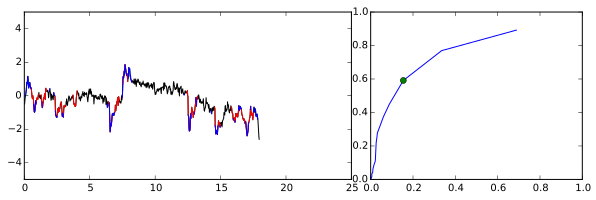

In [26]:
w = interactive(plot_setting,k_idx=(0,len(ksizes)-1),
                             m_idx=(0,len(mysizes)-1),
                             t_idx=(0,len(thresh_vals)-1),
                             sweep=(0,shape(ground_truth_mtrx)[0]-1))
display(w)

## Apply the saccade detector to the rest of the data set

In [27]:
w.kwargs

{'k_idx': 2, 'm_idx': 2, 'sweep': 1, 't_idx': 2}

In [78]:
#get the lmr datamatrix for a trial
#data_lmr = get_normed_trialmtrx('Ph2','yaw_left')
data_lmr = saccade_metadata['normed_signals']['Ph2']
#sort and normalize the data

thresh_vals = np.linspace(0,1.5,40)
ksizes  = np.array([11,21,41,81,161]).astype(int)
mysizes = np.arange(10,100,20)

filter_settings = {'kernel_size':ksizes[w.kwargs['k_idx']],
                   'mysize':mysizes[w.kwargs['m_idx']],
                   'thresh':thresh_vals[w.kwargs['t_idx']]}

detected_saccades = detect_saccades(data_lmr,**filter_settings)
detected_saccade_mtrx = convert_events_to_mtrx(detected_saccades,np.shape(data_lmr))

imshow(data_lmr,aspect = 'auto',interpolation = 'nearest')
figure()
imshow(detected_saccade_mtrx,aspect = 'auto',interpolation = 'nearest')

MemoryError: 

MemoryError: 

In [52]:
def event_distances(event,lmr):
    v = [(event[-1]-event[-0]),(lmr[event[-1]]-lmr[event[0]])*-1]
    #v = [v[1],v[0]*-1]
    distances = np.zeros_like(event).astype(float)
    for pnt_idx in event:
        r = [lmr[pnt_idx]-lmr[event[0]],pnt_idx-event[0]]
        #print np.dot(r,v/np.linalg.norm(v))
        distances[pnt_idx-event[0]] = np.dot(r,v/np.linalg.norm(v))
    return distances

def event_peaks(event,distances):
    return np.argmax(np.abs(distances))+ event[0]

In [53]:
saccade_distances = [[event_distances(event,sweep) for event in event_list] for 
                                                       event_list,sweep in zip(detected_saccades,data_lmr)]

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


In [54]:
saccade_peaks = [[event_peaks(event,distances) for event,distances in zip(event_list,distances_list)] for 
                                                       event_list,distances_list in zip(detected_saccades,
                                                                                        saccade_distances)]

In [55]:
lmr_db = list()
i1_db = list()
for row,event_list,distances_list,peaks_list in zip(arange(len(saccade_peaks)),
                                                    detected_saccades,
                                                    saccade_distances,
                                                    saccade_peaks):
    for event,distances,peak in zip(event_list,distances_list,peaks_list):
        try:
            if len(event)>5:
                lmr_db.append([event,distances,peak,row,data_lmr[row,np.arange(peak-20,peak+50)]])
                i1_db.append([event,distances,peak,row,data_i1[row,np.arange(peak-20,peak+50)]])
        except IndexError:
            pass

In [37]:
#lns = [plot(x[0]-x[2], x[-1],alpha = 0.5,color = 'k') for x in ex[:300] if mean(x[1])>0]
#gca().set_xbound(-10,10)
#detected_saccades[0]
#saccade_peaks[0]

In [50]:
del(ex)

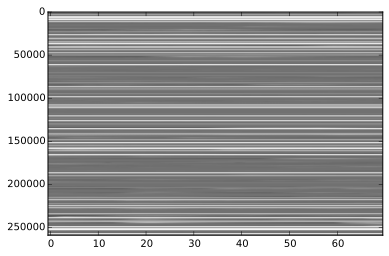

In [67]:
amps = np.squeeze(np.array([x[1][x[2]-x[0][0]] for x in lmr_db]))
sort_idx = np.argsort(amps,axis = 0)

traces_i1 = np.array([x[-1] - np.mean(x[-1]) for x in i1_db])
traces_i1 = traces_i1[sort_idx]

traces_lmr = np.array([x[-1] - np.mean(x[-1]) for x in lmr_db])
traces_lmr = traces_lmr[sort_idx]

imshow(traces_i1,aspect ='auto',cmap = cm.gray)

In [69]:
#figure(figsize = (5,10))
quantile_ranges = np.linspace(0,np.shape(traces)[0],11).astype(int)[::-1]
def show_saccade_quantile(col,row):
    if col == 0:
        range_start = quantile_ranges[row+1]
        range_stop = quantile_ranges[row]
        data_chunk = traces_lmr[range_start:range_stop,:] 
        xextent = shape(data_chunk)[1]
        imshow(data_chunk,
           aspect = 'auto',interpolation = 'nearest',
           vmin =-3,vmax = 3,
           extent = [0,xextent,-2,2],
           cmap = cm.BrBG)
        plot(np.nanmean(data_chunk,axis = 0))
    if col == 1:
        range_start = quantile_ranges[row+1]
        range_stop = quantile_ranges[row]
        data_chunk = traces_i1[range_start:range_stop,:] 
        xextent = shape(data_chunk)[1]
        imshow(data_chunk,
           aspect = 'auto',interpolation = 'nearest',
           vmin =-3,vmax = 3,
           extent = [0,xextent,-2,2],
           cmap = cm.BrBG)
        plot(np.nanmean(data_chunk,axis = 0))    


#subplot(2,1,1)
#lns = plot(traces[-550:-500].T,color = 'b',alpha = 0.2)
#subplot(2,1,2)
#lns = plot(traces[500:550].T,color = 'r',alpha = 0.2)

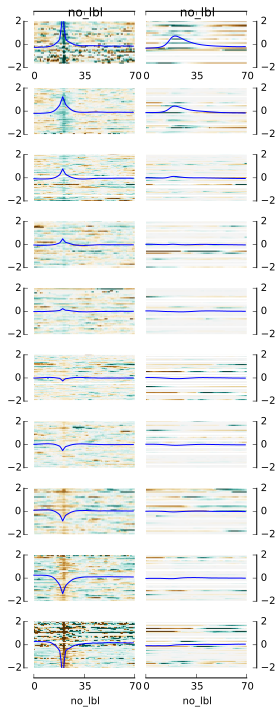

In [70]:
import plotfuncs as plf
reload(plf)
ax_handles = plf.plot_data_matrix(rows = 10,cols = 2,
                                  plot_panel_function = show_saccade_quantile,
                                  figsize = (4,10),
                                  xbounds = (0,70),
                                  ybounds = (-2,2),
                                  row_labels_left = None)

In [ ]:
distance_mtrx = convert_events_to_mtrx(detected_saccades,np.shape(data_lmr),scalings = saccade_distances)

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


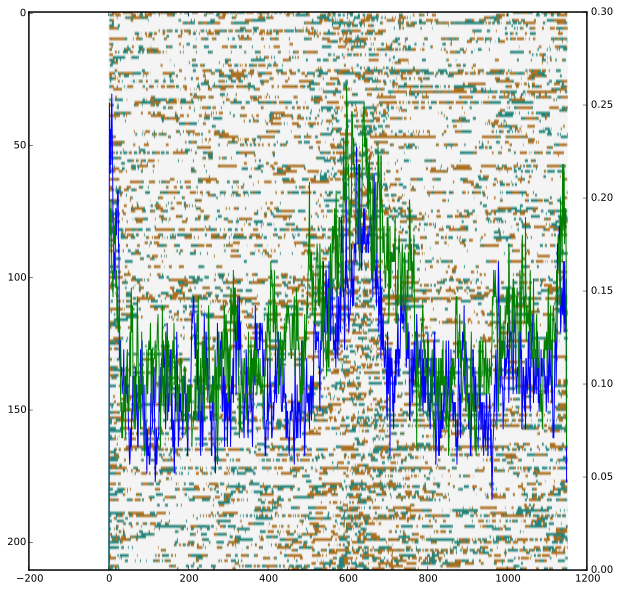

In [94]:
figure(figsize = (10,10))
imshow((distance_mtrx>0).astype(int) - (distance_mtrx<0).astype(int),aspect = 'auto',vmin = -1.5,vmax = 1.5,cmap = cm.BrBG)
twinx()
plot(np.nanmean(distance_mtrx>0,axis = 0))
plot(np.nanmean((distance_mtrx<0),axis = 0))

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


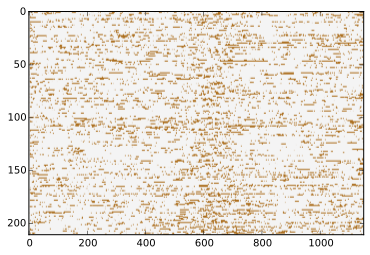

In [73]:
imshow(zeros_like(distance_mtrx) - (distance_mtrx<0).astype(int),aspect = 'auto',vmin = -1.5,vmax = 1.5,cmap = cm.BrBG)

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


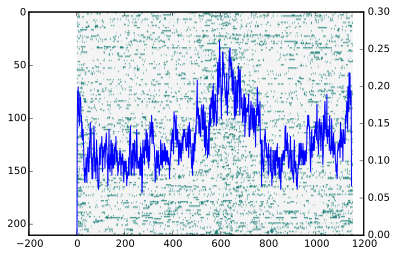

In [90]:
imshow(distance_mtrx>0,aspect = 'auto',vmin = -1.5,vmax = 1.5,cmap = cm.BrBG)
twinx()
plot(np.nanmean((distance_mtrx<0).astype(int),axis = 0))

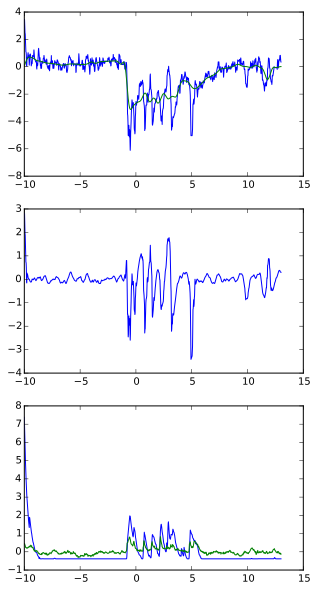

In [460]:
ndata = get_normed_trialmtrx('Ph2','yaw_left')
xi = get_xio('yaw_left')
import flylib as flb
idx = -1
figure(figsize = (5,10))
from scipy import signal
subplot(3,1,1)
filtdata = ndata
plot(xi,ndata[idx])
trenddata = apply_along_axis(signal.medfilt,1,filtdata,kernel_size = 61)
trenddata = apply_along_axis(flb.butter_lowpass_filter,1,trenddata,1.6,0.021)
#trenddata = apply_along_axis(signal.wiener,1,filtdata,mysize =200)
plot(xi,trenddata[idx])
subplot(3,1,2)
detrend = ndata-trenddata
#plot(xi,detrend[idx])
filtdata = apply_along_axis(signal.wiener,1,detrend,mysize =20)
plot(xi,filtdata[idx])
subplot(3,1,3)
plot(xi,get_normed_trialmtrx('i1','yaw_left')[idx])
plot(xi,get_normed_trialmtrx('b1','yaw_left')[idx])

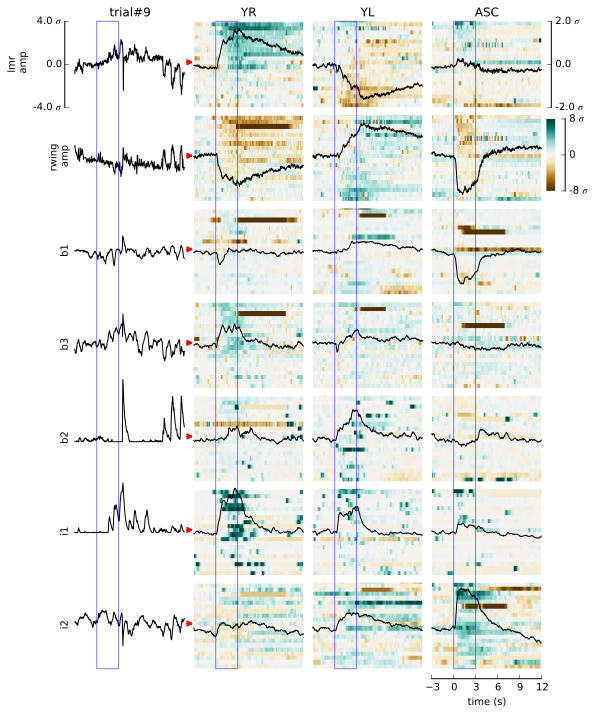

In [184]:
#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
reload(pf)

signal = 'iii3'
example_trial = 9
trial = 'yaw_left'
col_keys = ['yaw_left','yaw_right','ascending']
row_keys = ['Ph2','Ph1','b1','b3','b2','i1','i2']

pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)+1

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]
#row_labels_right[0] = 'trial number'

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-3,12) for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = [trial_to_label[trial] for trial in col_keys]
col_labels_top = ['trial#%s'%(example_trial)] + col_labels_top

show_spines_left = [False for j in range(rows)]
show_spines_left[0] = True
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [3 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]
col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False}
figsize = (8,10)

def get_sort_idx(signal,trial):
    selection = (data['signal_names'] == signal) & \
                (data['trial_names'] == trial) & \
                (data['flt_samples'] > 800) & \
                mask
    data_selection = data['signal_data'][selection,:]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>0) & (xi <3))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    normed_selection = subtracted_selection/signal_norms[signal]
    #normed_selection = subtracted_selection/ np.nanstd(subtracted_selection[:,baseline_idx])
    
    sort_idx = argsort(mean(normed_selection[:,stim_idx],axis = 1))
    return sort_idx

yleft_idx = get_sort_idx('Ph2','yaw_left')
yright_idx = get_sort_idx('Ph2','yaw_right')
tup_idx = get_sort_idx('Ph2','ascending')
tdown_idx = get_sort_idx('Ph2','descending')
    
def norm_sig(sig):
    sig -= np.min(sig)
    sig /= np.max(sig)
    return sig

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    if col > 0:
        signal = row_keys[row]
        trial = col_keys[col-1]
        selection = (data['signal_names'] == signal) & \
                    (data['trial_names'] == trial) & \
                    (data['flt_samples'] > 800) & \
                    mask
        data_selection = data['signal_data'][selection,:]
        xi = get_xio('yaw_left')
        baseline_idx = xi<0
        stim_idx = ((xi>0) & (xi <3))
        subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
        normed_selection = subtracted_selection/np.nanstd(subtracted_selection[:,baseline_idx])

        if trial == 'yaw_left':
            sort_idx = yleft_idx
        elif trial == 'yaw_right':
            sort_idx = yright_idx
        elif trial == 'ascending':
            sort_idx = tup_idx
        elif trial == 'descending':
            sort_idx = tdown_idx
        sorted_selection = normed_selection[sort_idx[::-1]]

        imshow(sorted_selection[::10],aspect = 'auto',cmap = cm.BrBG,extent = (xi[0],xi[-1],0,shape(sorted_selection)[0]),
              vmin = -7,vmax = 7,interpolation = 'nearest')
        sig = np.mean(sorted_selection,axis = 0)
        interval = 190/nsweeps

        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        #scale mean plots so that 0-200 maps onto -2 to 2
        plot(xi[pltidx],sig[pltidx]*(400/8.0) + 100,clip_on = False,color = 'k')
    if col == 0:
        signal = row_keys[row]
        trial = col_keys[col]
        selection = (data['signal_names'] == signal) & \
                    (data['trial_names'] == trial) & \
                    (data['flt_samples'] > 800) & \
                    mask
        data_selection = data['signal_data'][selection,:]
        xi = get_xio('yaw_left')
        baseline_idx = xi<0
        stim_idx = ((xi>0) & (xi <3))
        subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
        normed_selection = subtracted_selection/np.nanstd(subtracted_selection[:,baseline_idx])
        sort_idx = yleft_idx
        sorted_selection = normed_selection[sort_idx[::-1]]
        sig = sorted_selection[::10][example_trial]
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        #scale mean plots so that 0-200 maps onto -2 to 2
        plot(xi[pltidx],sig[pltidx]*(100/8.0) + 100,clip_on = False,color = 'k')

import plotfuncs as pf
reload(pf)

ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

#move the titles up a bit to accomidate the extra traces
#[ax.title.set_position((0.5,1.2)) for ax in ax_grid[0]]
#[ax[1].title.set_position((0.5,1.2)) for ax in ax_grid[0]]

#add annotations to indicate where the traces came from
interval = 190/nsweeps

[ax.set_zorder(11) for ax in col_ep_pans];

draw()
#rect = l,b,w,h
rect = 0.93,0.73,0.025,0.1
gcf().add_axes(rect)
#gca().set_ylabel(u' $\u0394$ F',rotation = -90,va = 'bottom')
gca().yaxis.set_label_position("right")
imshow(np.array([np.linspace(8,-8)]).T,cmap = cm.BrBG,extent = (0,1,-4,4))
yticks(np.linspace(-4,4,3))
gca().set_yticklabels([u'-8 $\u03C3$','0',u'8 $\u03C3$'])
pf.kill_spines()
gca().spines['right'].set_visible(True)
gca().spines['right'].set_position(('outward',10))

plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
[y.set_visible(False) for y in gca().get_yticklines()[::2]]

lbax = ax_grid[0][-1][1]
new_labels = [str(x) for x in linspace(-2,2,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels,y=2)
#for lbl in lbax.yaxis.get_major_ticks():
#    lbl.label2.set_text('3')

lbax = ax_grid[0][0]
new_labels = [str(x) for x in linspace(-4,4,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
#tklbls = lbax.get_yticklabels()
lbax.set_yticklabels(new_labels)

for row in ax_grid:
    sca(row[1])
    arr = matplotlib.patches.FancyArrowPatch(posA=(-4,200-(example_trial*10)-5), posB=(-3,200-(example_trial*10)-5), 
                              arrowstyle='->',  
                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
                              mutation_scale=10.0, mutation_aspect=None, dpi_cor=1.0,clip_on = False,color = 'r',
                              lw=2)
    gca().add_patch(arr)

draw()
savefig('trial_rasters_with_examples_sorted_by_behavior.pdf')

In [171]:
def get_normed_data(signal,trial):
    selection = (data['signal_names'] == signal) & \
                (data['trial_names'] == trial) & \
                (data['flt_samples'] > 800) & \
                mask
    data_selection = data['signal_data'][selection,:]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>0) & (xi <3))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    normed_selection = subtracted_selection/ np.nanstd(subtracted_selection[:,baseline_idx])
    sort_idx = get_sort_idx('Ph2',trial)
    return normed_selection[sort_idx[::-1]]

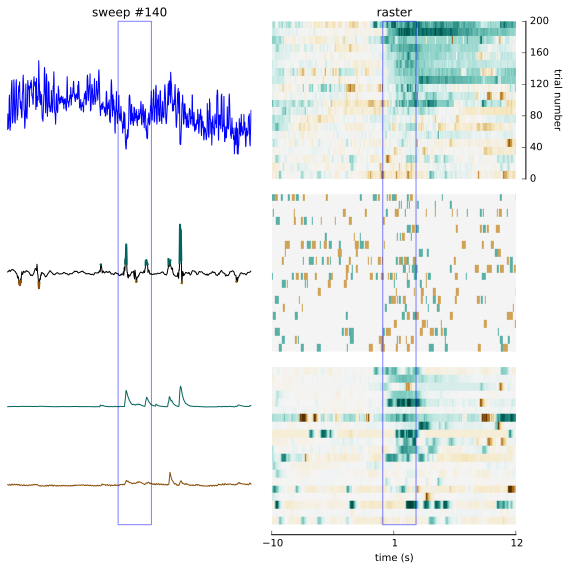

In [799]:
ims_kwargs = {'aspect':'auto','interpolation':'nearest','cmap':cm.BrBG,'extent':(-10,12,0,200)}
#fig = figure(figsize = (15,3))
thresh = 0.5
idx = 14
psaccads = filtdata > thresh
nsaccads = filtdata < thresh*-1
def plot_fun(col,row):
    #subplot(1,4,1)
    if row == 0:
        if col == 1:
            imshow(ndata[::10],vmin = -7,vmax = 7,**ims_kwargs)
        if col == 0:
            plot(xi,get_normed_data('Ph1','yaw_left')[::10][idx]*20+100)
    if row == 1:
        if col == 1:
            imshow((psaccads.astype(float) - nsaccads.astype(float))[::10],vmin = -2,vmax = 2,**ims_kwargs)
        if col == 0:
            fd = filtdata[::10][idx]
            plot(xi,fd*20+100,color = 'k')
            fd = filtdata[::10][idx].copy()
            fd[fd<thresh] = np.nan
            plot(xi,fd*20+100,color = cm.BrBG(0.9),lw = 2)
            fd = filtdata[::10][idx].copy()
            fd[fd>(thresh*-1)] = np.nan
            plot(xi,fd*20+100,color = cm.BrBG(0.1),lw = 2)
    if row == 2:
        if col == 1:
            imshow((get_normed_data('i1','yaw_left')-get_normed_data('b2','yaw_left'))[::10],
                vmin = -10,vmax = 10,**ims_kwargs)
        if col == 0:
            plot(xi,get_normed_data('i1','yaw_left')[::10][idx]*5+150,color = cm.BrBG(0.9))
            plot(xi,get_normed_data('b2','yaw_left')[::10][idx]*5+50,color = cm.BrBG(0.1))

pltrng = (-3,12)

rows = 3#len(row_keys)
cols = 2#len(col_keys)

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]
#row_labels_right[0] = 'trial number'

#nsweeps = 4

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-10,12) for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [None]
#row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = ['sweep #%s'%(idx*10),'raster']

show_spines_left = False
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [6 for j in range(rows)]
xtick_numbers = [3 for i in range(cols)]

ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_fun,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = (8,8),
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False})
[ax.set_zorder(11) for ax in col_ep_pans];
savefig('saccade_comparison.pdf')

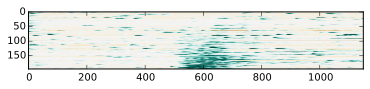

In [119]:
imshow(get_normed_data('i1','yaw_left'),cmap = cm.BrBG,vmin = -8,vmax = 8)

In [120]:
import flylib as flb

In [124]:
?flb.butter_lowpass_filter()

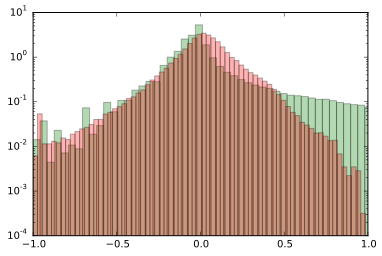

In [171]:
n, bins, patches = hist(i1_selection.ravel(),bins = 100,normed = True);
setp(patches, 'facecolor', 'g', 'alpha', 0.3)
n, bins, patches = hist(b3_selection.ravel(),bins = 100,normed = True);
setp(patches, 'facecolor', 'r', 'alpha', 0.3)
gca().set_xbound(-1,1)
gca().set_yscale('log')
#gca().set_ybound(0,3)

In [24]:
np.shape(np.mean(data_selection,axis = 1))

(196,)

In [ ]:
def get_trial_data(data,mask):
    """ Calculate the mean for each type 
    of trial - return in a dictionary keyed by signal and trial """
    #baseline_epoch = (xi >5) & (xi < 7)
    import group_data as gd
    reload(gd)
    ave_dict = dict()
    signal_set = set(data['signal_names'][mask])
    trial_set = set(data['trial_names'][mask])
    fly_set = set(data['fly_numbers'][mask])
    for signal in signal_set:
        ave_dict[signal] = dict()
        for trial in trial_set:
            ave_dict[signal][trial] = dict()
            for fly in fly_set:
                
                selection = (data['fly_numbers'] == fly) & \
                            (data['signal_names'] == signal) & \
                            (data['trial_names'] == trial) & \
                            (data['flt_samples'] > 800) & \
                            mask
                            
                if sum(selection) >0:
                    datamtrx = data['signal_data'][selection,:]
                    xi = get_xio(trial)
                    baseline_epoch = (xi >-3) & (xi < 0)
                    baseline = np.nanmean(data['signal_data'][selection][:,baseline_epoch],axis = 1)
                    datamtrx -= baseline[:,np.newaxis] #delta F
                    ave_dict[signal][trial][fly] = np.nanmean(datamtrx,axis = 0)
    return ave_dict